In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.plotting import line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

datadir = Path("../data/")

In [6]:
filepath = datadir / "STORM/desmin_actin_2.5um.csv"
df = pl.read_csv(filepath)
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
out = df.partition_by("probe")

Text(0.5, 0.01, 'x (μm)')

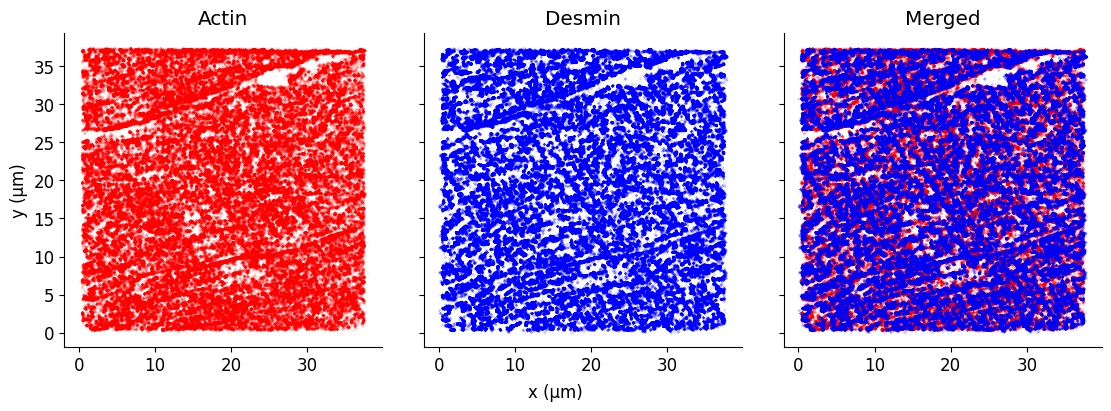

In [3]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.05,
        c="red",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.05,
        c="blue",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Actin", "Desmin", "Merged")):
    ax.axis("equal")

    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

2025-11-08 12:22:04.089 (  18.745s) [    15141EAD1740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


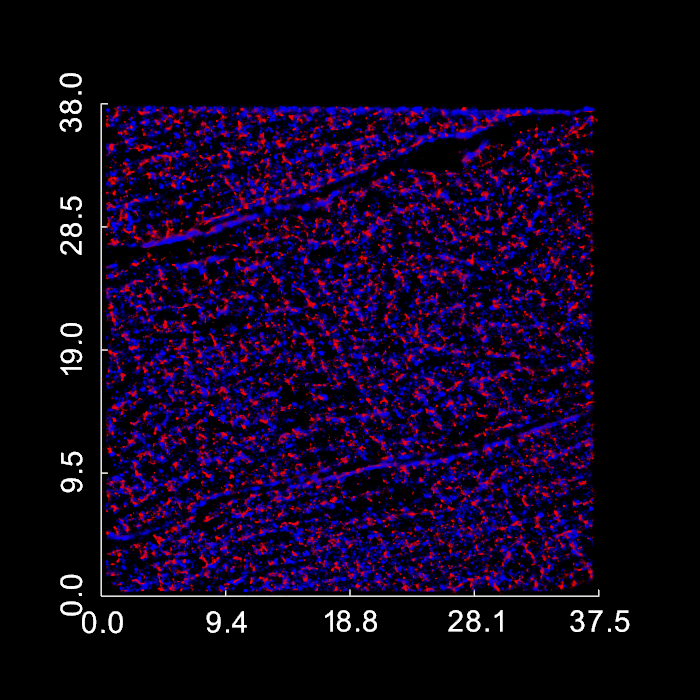

In [4]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=0.5,
    opacity=0.1,
)
point_cloud = pv.PolyData(out[0].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=1.0,
    opacity=0.1,
)
p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="white",
    grid=None,
    axes_ranges=[0, 37.5, 0, 38, 0, 0],
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()

In [5]:
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

100%|██████████| 1552301/1552301 [06:03<00:00, 4272.89it/s]


In [6]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]

100%|██████████| 10/10 [1:18:34<00:00, 471.41s/it]


In [7]:
voro_vol_rands_ = [np.stack(v, axis=0) for v in voro_vol_rands]
for v in voro_vol_rands_:
    print(v.shape)

(10, 626141)
(10, 1552301)


In [8]:
savepath = "../data/results/desmin_actin_2.5um_voronoi_volumes.npz"
np.savez(
    savepath,
    desmin=voro_vols[0],
    actin=voro_vols[1],
    desmin_random=voro_vol_rands_[0],
    actin_random=voro_vol_rands_[1],
)

In [2]:
voronoi_volumes = np.load(datadir / "results/desmin_actin_2.5um_voronoi_volumes.npz")

In [3]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins)


def internal_division_point(x1, x2, y1, y2):
    return (y1 * x2 + y2 * x1) / (y1 + y2)


def find_crossing_points(x, y1, y2):
    y_diff = y1 - y2
    x_exact_crossing = x[np.flatnonzero(y_diff == 0)]

    ind_sign_change = np.flatnonzero(y_diff[:-1] * y_diff[1:] <= 0)
    print(ind_sign_change)
    x_interped_crossing = internal_division_point(
        x[ind_sign_change],
        x[ind_sign_change + 1],
        y_diff[ind_sign_change],
        -y_diff[ind_sign_change + 1],
    )
    x_crossing = np.concatenate((x_exact_crossing, x_interped_crossing), axis=0)
    return np.sort(x_crossing)

[10 74]
[ 3 31]


Text(0.5, 0.01, 'Voronoi cell volume (μm³)')

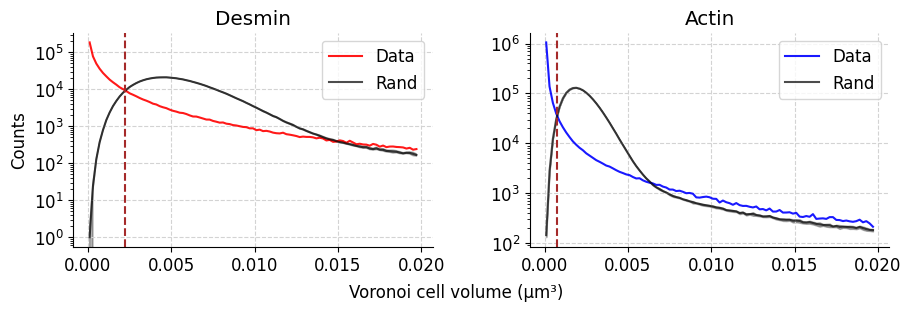

In [5]:
vol_thresholds = []

fig, axes = plt.subplots(
    1, 2, figsize=(9, 3), constrained_layout=True, gridspec_kw={"wspace": 0.1}
)
names = ("desmin", "actin")
color_dict = {"desmin": "red", "actin": "blue"}
title_dict = {"desmin": "Desmin", "actin": "Actin"}
for ax, n in zip(axes, names):
    counts, bin_edges = histogram_fixed_binsize(
        voronoi_volumes[n], bin_size=2e-4, max_value=2e-2
    )
    counts_rand = np.stack(
        [
            histogram_fixed_binsize(vol, bin_size=2e-4, max_value=2e-2)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label="Data")
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Rand",
    )
    ax.set_yscale("log")

    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds.append(vol_thres)
    ax.axvline(
        x=vol_thres,
        linestyle="--",
        color="brown",
    )
    ax.legend()
    ax.grid(ls="--", color="lightgray")
    ax.set_title(title_dict[n])
axes[0].set_ylabel("Counts")
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="medium")

In [7]:
df_filtered = [
    pl.concat(
        (
            out[i],
            pl.DataFrame({"voronoi_volume": voronoi_volumes[n]}),
        ),
        how="horizontal",
    ).filter(pl.col("voronoi_volume") <= vol_thresholds[i])
    for i, n in enumerate(("desmin", "actin"))
]
df_filtered_total = pl.concat(df_filtered)

In [8]:
df_filtered_total.write_csv("../data/results/desmin_actin_2.5um_filtered.csv")

In [9]:
df = pl.read_csv("../data/results/desmin_actin_2.5um_filtered.csv")
out = df.partition_by("probe")

Text(0.5, 0.01, 'x (μm)')

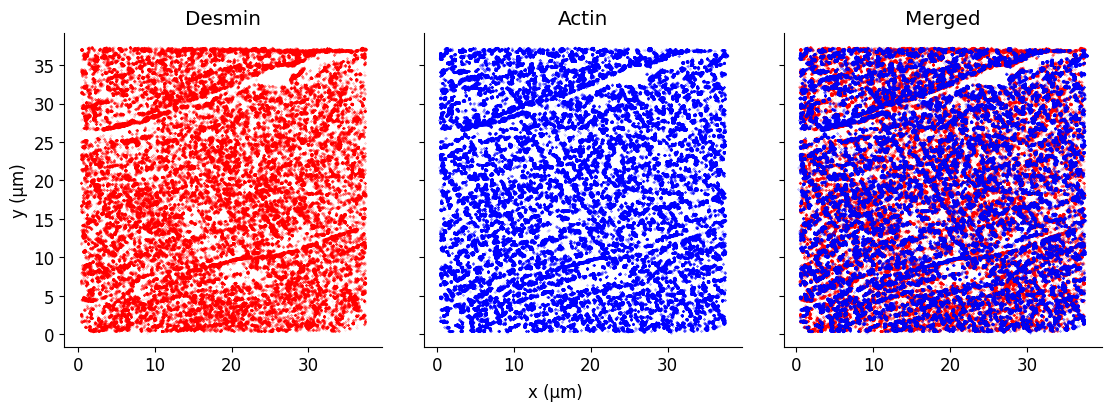

In [10]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(11, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        s=0.05,
        c="red",
        # c=np.log10(out[0]["amp"]),
        # cmap=cc.cm.kr_r,
        alpha=0.3,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        s=0.05,
        c="blue",
        # c=np.log10(out[1]["amp"]),
        # cmap=cc.cm.kg_r,
        alpha=0.3,
    )

for ax, title in zip(axes, ("Desmin", "Actin", "Merged")):
    ax.axis("equal")

    ax.set_title(title)
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

/home/jhko725/projects/desmin_reconstruction/.venv/lib/python3.12/site-packages/pyvista/core/utilities/points.py:77: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


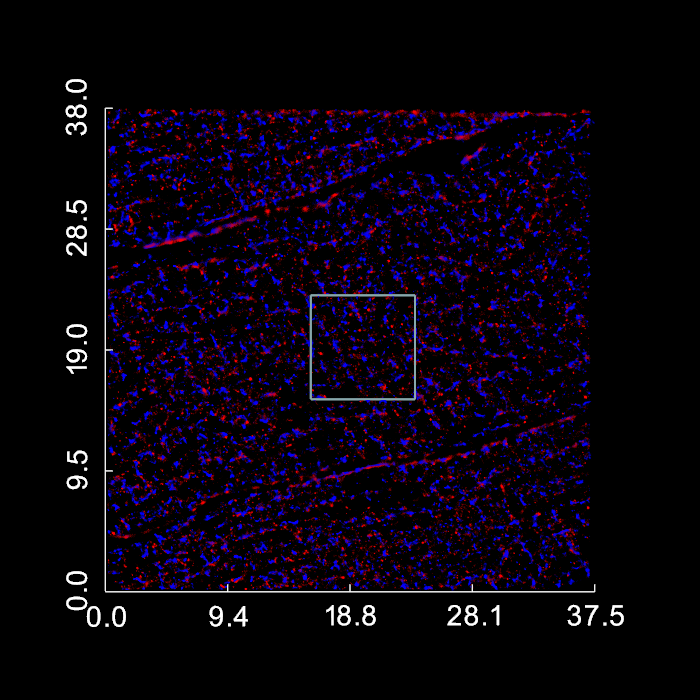

In [45]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(out[0].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=0.5,
    opacity=0.1,
)
point_cloud = pv.PolyData(out[1].select(["x", "y", "z"]).to_numpy())
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=0.5,
    opacity=0.1,
)
rect = pv.Rectangle([[16, 15, 10], [24, 23, 10], [16, 23, 10]])

p.add_mesh(
    rect,
    show_edges=True,
    style="wireframe",
    edge_color="white",
    line_width=2.0,
    opacity=1.0,
)
p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="#FFFFFF",
    grid=None,
    axes_ranges=[0, 37.5, 0, 38, 0, 0],
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()

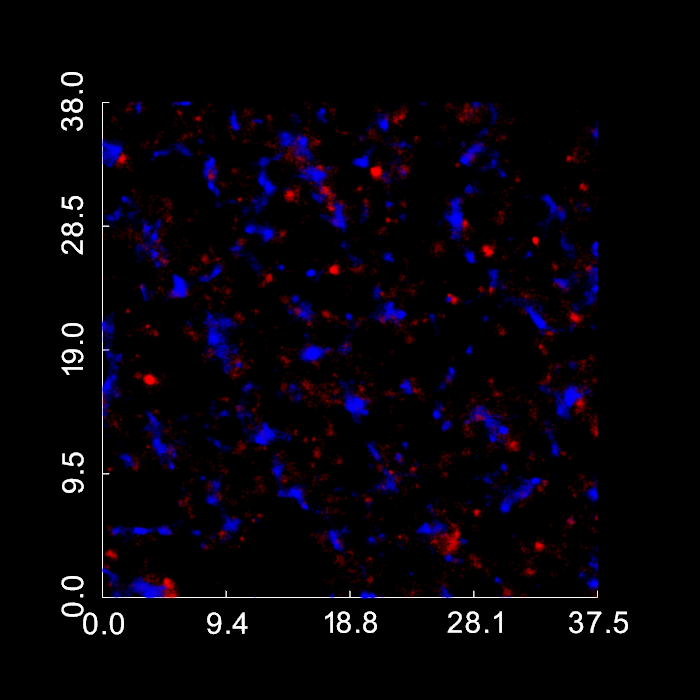

In [46]:
bbox = BoundingSquare(16, 15, side=8)
points = [df.select(["x", "y", "z"]).to_numpy() for df in out]
points_bbox = [filter_bounded(pts, bbox) for pts in points]

p = pv.Plotter(notebook=True, window_size=(700, 700))
point_cloud = pv.PolyData(points_bbox[0])
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#FF0000",
    style="points_gaussian",
    # emissive=True,
    point_size=1.5,
    opacity=0.1,
)
point_cloud = pv.PolyData(points_bbox[1])
point_cloud = point_cloud.project_points_to_plane(origin=[0, 0, 0], normal=[0, 0, 1])
p.add_mesh(
    point_cloud,
    color="#0000FF",
    style="points_gaussian",
    # emissive=True,
    point_size=1.5,
    opacity=0.1,
)

p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="#FFFFFF",
    grid=None,
    axes_ranges=[0, 37.5, 0, 38, 0, 0],
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
# axis.x_axis_label_visibility = False
# axis.y_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()